In [2]:

import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
import torch.nn.functional as F
from load_model import *
# # Hiển thị các channel đã chọn dưới dạng lưới
import matplotlib.pyplot as plt

import matplotlib.gridspec as gridspec
from PIL import Image
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Tiền xử lý ảnh
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Trích xuất feature maps từ tất cả các stage (stem + 4 stages)
def extract_feature_maps_all_stages(model, img_tensor):
    with torch.no_grad():
        features = []
        x = model.stem(img_tensor)
        features.append(x)
        for stage in model.stages:
            x = stage(x)
            features.append(x)
    return features  # List các tensor [1, C, H, W]

# Chuẩn hóa riêng từng feature map để scale về [0, 1]
def normalize_feature_map(fmap):
    fmap = fmap - fmap.min()
    fmap = fmap / (fmap.max() + 1e-10)
    return fmap

# Lấy top k channels theo tổng giá trị tuyệt đối (activation mạnh nhất)
def get_topk_channels(fmap, k=10):
    fmap_abs = fmap.abs()
    channel_sums = fmap_abs.sum(dim=[2,3])  # [1, C]
    topk_vals, topk_idx = torch.topk(channel_sums, k, dim=1)
    return topk_idx[0].cpu().numpy()  # Trả về indices



def visualize_top2_channels_each_stage_including_stem(img_path, model):
    # Đọc ảnh gốc
    img = Image.open(img_path).convert('RGB')
    img_tensor = preprocess(img).unsqueeze(0).to(device)

    # Lấy feature maps các stage (dạng list tensor: [1, C, H, W])
    features = extract_feature_maps_all_stages(model, img_tensor)

    # Resize tất cả feature maps về 224x224 cho đồng bộ hiển thị
    # features_resized = [F.interpolate(fmap, size=(224, 224), mode='bilinear', align_corners=False) for fmap in features]
    features_resized = features
    top_feature_maps = []
    titles = []

    for stage_idx, fmap in enumerate(features_resized):  # Duyệt từng stage
        fmap_abs = fmap.abs()  # [1, C, H, W]
        channel_sum = fmap_abs.sum(dim=[2, 3]).squeeze(0)  # Tổng kích hoạt mỗi channel [C]

        # Lấy 2 channel có kích hoạt cao nhất
        top2_idx = torch.topk(channel_sum, k=2).indices.tolist()

convnext_v2
E:/NghienCuuKhoaHoc/INDEX/convnext_v2/pca_convnext_v2_aug.pkl


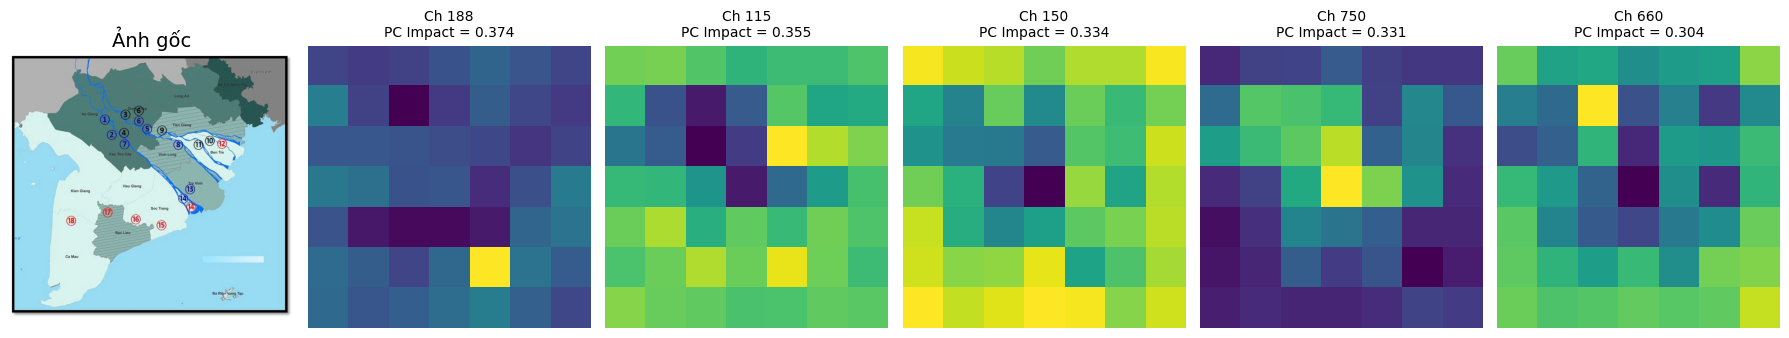

In [7]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torchvision import transforms
from load_model import *
from image_search import *  

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Tiền xử lý ảnh
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Trích đặc trưng từ CNN
def extract_feature_map(model, img_tensor):
    with torch.no_grad():
        x = model.stem(img_tensor)
        for stage in model.stages:
            x = stage(x)
    return x  # [1, C, H, W]

# Tính SPoC vector từ feature map
def extract_spoc_vector(feature_map):
    spoc_vector = feature_map.sum(dim=[2, 3])  # [1, C]
    spoc_vector = spoc_vector / torch.norm(spoc_vector, dim=1, keepdim=True)
    return spoc_vector.squeeze(0)  # [C]

def visualize_top5_spoc_channels(img_path, model):
    from matplotlib import gridspec

    img = Image.open(img_path).convert('RGB')
    img_tensor = preprocess(img).unsqueeze(0).to(device)

    # Trích đặc trưng
    fmap = extract_feature_map(model, img_tensor)          # [1, C, H, W]
    spoc_vector = extract_spoc_vector(fmap).cpu().numpy()  # [C]

    # Chọn 5 kênh có giá trị SPoC lớn nhất
    top5_idx = np.argsort(-spoc_vector)[:5]

    fmap_np = fmap.squeeze(0).cpu().numpy()

    # Vẽ ảnh gốc bên trái, 5 kênh bên phải, 1 hàng 6 cột
    fig = plt.figure(figsize=(18, 4))
    gs = gridspec.GridSpec(1, 6, width_ratios=[1.5, 1, 1, 1, 1, 1])

    # Ảnh gốc ở cột 0
    ax_img = plt.subplot(gs[0])
    ax_img.imshow(img)
    ax_img.axis('off')
    ax_img.set_title('Ảnh gốc', fontsize=14)

    # Vẽ 5 kênh feature map
    for i, idx in enumerate(top5_idx):
        channel_map = fmap_np[idx]
        channel_map_norm = (channel_map - channel_map.min()) / (channel_map.max() - channel_map.min() + 1e-10)

        ax = plt.subplot(gs[i + 1])
        ax.imshow(channel_map_norm, cmap='viridis')
        ax.axis('off')
        ax.set_title(f'Ch {idx}\nSPoC={spoc_vector[idx]:.3f}', fontsize=10)

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

def visualize_top5_spoc_channels_with_pca(img_path, model):
    from matplotlib import gridspec

    img = Image.open(img_path).convert('RGB')
    img_tensor = preprocess(img).unsqueeze(0).to(device)

    # Trích đặc trưng
    fmap = extract_feature_map(model, img_tensor)          # [1, C, H, W]
    spoc_vector = extract_spoc_vector(fmap).cpu().numpy()  # [C]

    # Load PCA model (biến global pca đã được gán)
    load_pca('convnext_v2')

    # Áp dụng PCA lên vector SPoC
    pca_vector = apply_pca(spoc_vector)

    global pca
    pca_components = pca.components_  # shape: [num_components, C]

    # Tính độ ảnh hưởng từng channel đến 5 thành phần PCA đầu (kênh càng có giá trị tuyệt đối cao trong PCA components thì càng ảnh hưởng)
    importance = np.sum(np.abs(pca_components[:5, :]), axis=0)  # [C]

    # Chọn top 5 channel có độ ảnh hưởng lớn nhất
    top5_idx = np.argsort(-importance)[:5]

    fmap_np = fmap.squeeze(0).cpu().numpy()

    # Vẽ ảnh gốc + 5 channel
    fig = plt.figure(figsize=(18, 4))
    gs = gridspec.GridSpec(1, 6, width_ratios=[2] + [2]*5)

    ax_img = plt.subplot(gs[0])
    ax_img.imshow(img)
    ax_img.axis('off')
    ax_img.set_title('Ảnh gốc', fontsize=14)

    for i, idx in enumerate(top5_idx):
        channel_map = fmap_np[idx]
        channel_map_norm = (channel_map - channel_map.min()) / (channel_map.max() - channel_map.min() + 1e-10)

        ax = plt.subplot(gs[i + 1])
        ax.imshow(channel_map_norm, cmap='viridis')
        ax.axis('off')
        ax.set_title(f'Ch {idx}\nPC Impact = {importance[idx]:.3f}', fontsize=10)

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()



model_convnext_v2 = load_convnextv2_model(
    r'E:\NghienCuuKhoaHoc\MODEL\convnext_v2\convnext_v2_best_params_aug_final.pth',
    11,
    "convnext_v2_aug"
)
model_convnext_v2.to(device).eval()
img_path = 'E:/LuanVan/data/raw/Maps/04-BE-VO NAM SON(24-38)004_page_26_img_1.png'

visualize_top5_spoc_channels_with_pca(img_path, model_convnext_v2)


Resnet 101

Model loaded
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


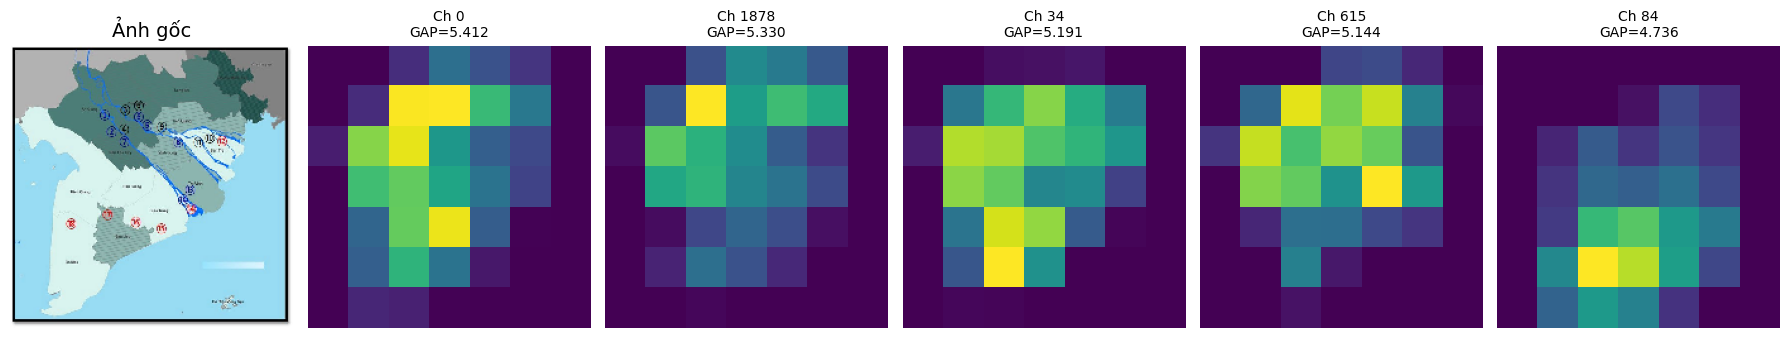

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing import image

def load_keras_model(model_path):
    model = load_model(model_path)
    print("Model loaded")
    return model

def extract_gap_vector(model, img_path):
    # Load ảnh, resize theo chuẩn ResNet101 (224x224)
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # scale 0-1
    img_array = np.expand_dims(img_array, axis=0)

    # Tạo model chỉ output GAP layer
    gap_layer_name = "global_average_pooling2d"  # đổi nếu tên khác
    gap_model = Model(inputs=model.input, outputs=model.get_layer(gap_layer_name).output)

    gap_vector = gap_model.predict(img_array)  # shape (1, C)
    gap_vector = gap_vector.squeeze()          # shape (C,)
    return gap_vector, img

def extract_feature_map(model, img_path):
    # Nếu muốn lấy feature map (ví dụ conv cuối trước GAP)
    # Thay đổi tên layer này theo model của bạn
    conv_layer_name = "conv5_block3_out"  # ví dụ ResNet101 Keras
    conv_model = Model(inputs=model.input, outputs=model.get_layer(conv_layer_name).output)

    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    fmap = conv_model.predict(img_array)  # shape (1, H, W, C)
    fmap = np.squeeze(fmap)               # shape (H, W, C)
    # Chuyển sang (C, H, W) để dễ xử lý
    fmap = np.transpose(fmap, (2, 0, 1))
    return fmap, img

def visualize_top5_channels_gap(gap_vector, fmap, img):
    import matplotlib.pyplot as plt
    import numpy as np

    # Lấy chỉ số top 5 channel có giá trị GAP lớn nhất
    top5_idx = np.argsort(-np.abs(gap_vector))[:5]

    fig, axs = plt.subplots(1, 6, figsize=(18, 4))  # 1 hàng, 6 cột

    # Vẽ ảnh gốc ở cột đầu tiên
    axs[0].imshow(img)
    axs[0].axis('off')
    axs[0].set_title('Ảnh gốc', fontsize=14)

    # Vẽ 5 feature maps ở các cột kế tiếp
    for i, idx in enumerate(top5_idx):
        channel_map = fmap[idx]
        # Chuẩn hóa để hiển thị
        channel_map_norm = (channel_map - channel_map.min()) / (channel_map.max() - channel_map.min() + 1e-10)
        axs[i + 1].imshow(channel_map_norm, cmap='viridis')
        axs[i + 1].axis('off')
        axs[i + 1].set_title(f'Ch {idx}\nGAP={gap_vector[idx]:.3f}', fontsize=10)

    plt.tight_layout()
    # plt.suptitle('Top 5 kênh có GAP lớn nhất (cùng hàng với ảnh gốc)', fontsize=16)
    plt.subplots_adjust(top=0.85)
    plt.show()




if __name__ == "__main__":
    model_path = r"E:\NghienCuuKhoaHoc\MODEL\resnet101\tc-resnet101.keras"
    img_path = 'E:/LuanVan/data/raw/Maps/04-BE-VO NAM SON(24-38)004_page_26_img_1.png'

    model = load_keras_model(model_path)
    gap_vector, img = extract_gap_vector(model, img_path)
    fmap, _ = extract_feature_map(model, img_path)
    visualize_top5_channels_gap(gap_vector, fmap, img)


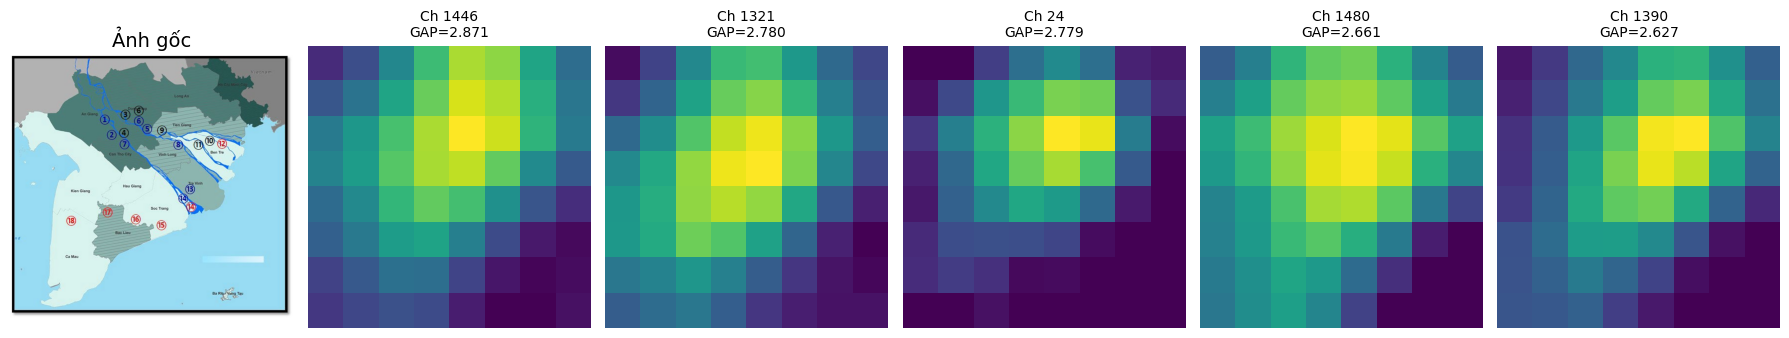

In [20]:
import torch
import timm
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

class InceptionV4Extractor(torch.nn.Module):
    def __init__(self, base_model):
        super(InceptionV4Extractor, self).__init__()
        self.base_model = base_model
        self.pooling = torch.nn.AdaptiveAvgPool2d((1, 1))  # GAP

    def forward(self, x):
        features = self.base_model.forward_features(x)
        pooled = self.pooling(features)
        pooled = pooled.view(pooled.size(0), -1)
        return pooled  # (B, 1536)

def load_inceptionv4_model(pth_path):
    base_model = timm.create_model('inception_v4', pretrained=False, num_classes=11)

    # Thay đổi fully-connected layers nếu cần
    in_feats = base_model.last_linear.in_features
    base_model.last_linear = torch.nn.Sequential(
        torch.nn.Dropout(0.25),
        torch.nn.Linear(in_feats, 256, bias=False),
        torch.nn.BatchNorm1d(256),
        torch.nn.ReLU(inplace=True),
        torch.nn.Dropout(0.326),
        torch.nn.Linear(256, 128, bias=False),
        torch.nn.BatchNorm1d(128),
        torch.nn.ReLU(inplace=True),
        torch.nn.Dropout(0.267),
        torch.nn.Linear(128, 11)
    )

    model = InceptionV4Extractor(base_model)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    base_model.load_state_dict(torch.load(pth_path, map_location=device))
    model.to(device).eval()
    return model

def extract_gap_vector_inceptionv4(model, img_path):
    device = next(model.parameters()).device
    transform = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])

    img = Image.open(img_path).convert("RGB")
    input_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        gap_vec = model(input_tensor).squeeze().cpu().numpy()  # (1536,)

    return gap_vec, img

def visualize_top5_gap_channels(gap_vector, fmap, img):
    top5_idx = np.argsort(-np.abs(gap_vector))[:5]

    fig, axs = plt.subplots(1, 6, figsize=(18, 4))
    axs[0].imshow(img)
    axs[0].axis('off')
    axs[0].set_title('Ảnh gốc', fontsize=14)

    for i, idx in enumerate(top5_idx):
        channel_map = fmap[idx]
        channel_map_norm = (channel_map - channel_map.min()) / (channel_map.max() - channel_map.min() + 1e-10)
        axs[i + 1].imshow(channel_map_norm, cmap='viridis')
        axs[i + 1].axis('off')
        axs[i + 1].set_title(f'Ch {idx}\nGAP={gap_vector[idx]:.3f}', fontsize=10)

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()



def extract_feature_map(model, img_path):
    device = next(model.parameters()).device
    transform = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    img = Image.open(img_path).convert("RGB")
    input_tensor = transform(img).unsqueeze(0).to(device)

    # Trích feature map trước GAP
    with torch.no_grad():
        fmap = model.base_model.forward_features(input_tensor)
        fmap = fmap.squeeze().cpu().numpy()  # shape: (C, H, W)

    return fmap, img

if __name__ == "__main__":
    model_path = r"E:\NghienCuuKhoaHoc\MODEL\inception_v4\IncepV4-aug.pth"
    img_path = r"E:/LuanVan/data/raw/Maps/04-BE-VO NAM SON(24-38)004_page_26_img_1.png"

    model = load_inceptionv4_model(model_path)
    gap_vector, img = extract_gap_vector_inceptionv4(model, img_path)
    fmap, _ = extract_feature_map(model, img_path)
    visualize_top5_gap_channels(gap_vector, fmap, img)


e:\NghienCuuKhoaHoc\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Found 3007 images belonging to 11 classes.
Class indices: {'Animal Samples': 0, 'Charts': 1, 'Chemical Structure': 2, 'Maps': 3, 'Microbial Cultures': 4, 'Micrographs': 5, 'Models And Diagrams': 6, 'Others': 7, 'PCR Gel Electrophoresis': 8, 'Photographs': 9, 'Plant Samples': 10}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
vgg16
E:/NghienCuuKhoaHoc/INDEX/vgg16/pca_vgg16_aug.pkl


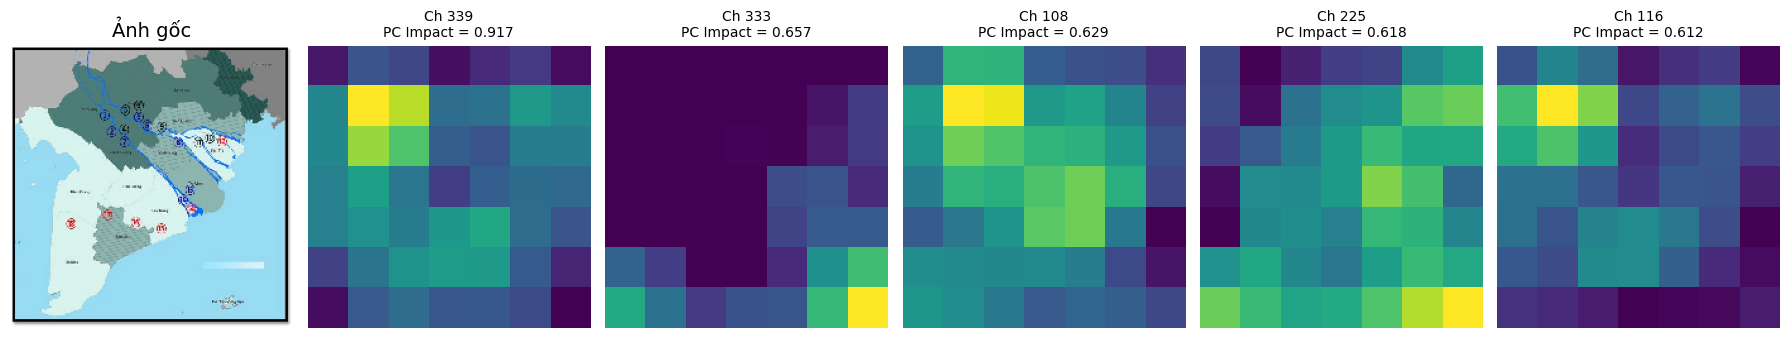

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing import image
from image_search import load_pca, apply_pca
from torchvision import transforms

def preprocess_img_vgg16(img_path):
    # img = image.load_img(img_path, target_size=(224, 224))
    # img_array = image.img_to_array(img) / 255.0
    # img_array = np.expand_dims(img_array, axis=0)
    # return img, img_array
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0 
    return img, img_array

def extract_feature_map_vgg16(model, img_array):
    conv_layer_name = 'block5_pool'
    intermediate_model = Model(inputs=model.input, outputs=model.get_layer(conv_layer_name).output)
    fmap = intermediate_model.predict(img_array)  # (1, H, W, C)
    fmap = np.squeeze(fmap)                       # (H, W, C)
    fmap = np.transpose(fmap, (2, 0, 1))         # (C, H, W)
    return fmap

def extract_spoc_vector(fmap):
    spoc_vector = np.sum(fmap, axis=(1,2))       # sum pooling over H,W
    spoc_vector /= np.linalg.norm(spoc_vector)   # normalize vector
    return spoc_vector

def visualize_top5_spoc_channels_with_pca_vgg16(img_path, model):
    img, img_array = preprocess_img_vgg16(img_path)
    fmap = extract_feature_map_vgg16(model, img_array)
    spoc_vector = extract_spoc_vector(fmap)

    # Load PCA
    load_pca('vgg16')  
    from image_search import pca  

    pca_vector = apply_pca(spoc_vector)
    
    pca_components = pca.components_
    C = fmap.shape[0]  # số channel = 512
    pca_components = pca_components[:, :C]  # giới hạn lại theo fmap

    importance = np.sum(np.abs(pca_components[:5, :]), axis=0)
    top5_idx = np.argsort(-importance)[:5]

    fig, axs = plt.subplots(1, 6, figsize=(18, 4))
    axs[0].imshow(img)
    axs[0].axis('off')
    axs[0].set_title("Ảnh gốc", fontsize=14)

    for i, idx in enumerate(top5_idx):
        channel_map = fmap[idx]
        channel_map_norm = (channel_map - channel_map.min()) / (channel_map.max() - channel_map.min() + 1e-10)
        axs[i+1].imshow(channel_map_norm, cmap='viridis')
        axs[i+1].axis('off')
        axs[i+1].set_title(f'Ch {idx}\nPC Impact = {importance[idx]:.3f}', fontsize=10)

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    model_path = r'E:\NghienCuuKhoaHoc\MODEL\vgg16\vgg16_aug_best_params_final.keras'
    img_path = r"E:/LuanVan/data/raw/Maps/04-BE-VO NAM SON(24-38)004_page_26_img_1.png"

    model = load_model(model_path, compile=False)
    visualize_top5_spoc_channels_with_pca_vgg16(img_path, model)


ResNet101

e:\NghienCuuKhoaHoc\venv\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


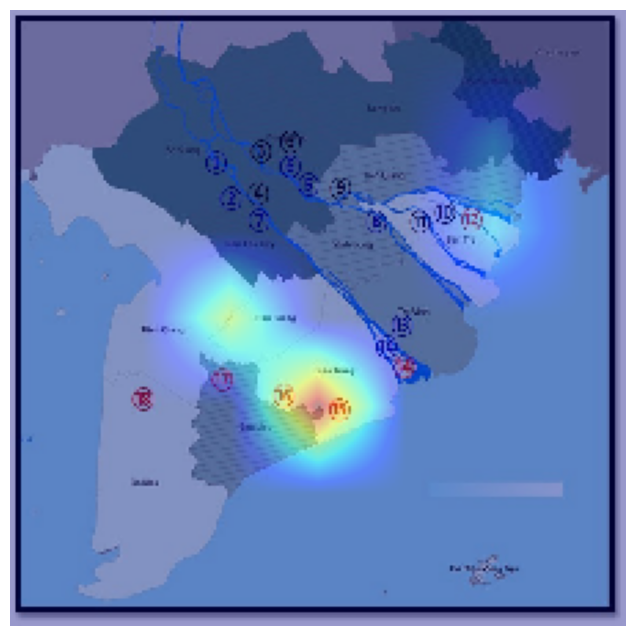

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import load_model, Model

# Preprocessing for Keras Models (VGG16)
def preprocess_keras_image(img, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array, img

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_output = predictions[:, pred_index]

    grads = tape.gradient(class_output, conv_outputs)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
import cv2

def display_gradcam(img, heatmap, alpha=0.4, cmap='jet'):
    heatmap = cv2.resize(heatmap, (img.size[0], img.size[1]))
    heatmap_color = plt.get_cmap(cmap)(heatmap)
    heatmap_color = np.uint8(255 * heatmap_color[..., :3])

    img_np = np.array(img)
    superimposed_img = cv2.addWeighted(img_np, 1 - alpha, heatmap_color, alpha, 0)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(superimposed_img)
    plt.axis('off')
    # plt.title("Grad-CAM")
    plt.show()

    # Load ảnh và mô hình
# img_path = r"E:\LuanVan\data\raw\Animal Samples\01-CN-HOANG THI NGHIEP(1-5)_page_3_img_1.png"
img_path = r"E:\LuanVan\data\raw\Maps\04-BE-VO NAM SON(24-38)004_page_26_img_1.png"

img_array, img = preprocess_keras_image(img_path)
model_path = r'E:\NghienCuuKhoaHoc\MODEL\resnet101\resnet101.keras'

# Lấy tên lớp conv cuối (VGG16 thường là 'block5_conv3')
last_conv_layer_name = 'conv5_block3_out'
model = load_model(model_path, compile=False)

# Tạo heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Hiển thị ảnh overlay Grad-CAM
display_gradcam(img, heatmap)



ConvNext V2

e:\NghienCuuKhoaHoc\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
e:\NghienCuuKhoaHoc\venv\Lib\site-packages\torch\nn\modules\module.py:1842: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


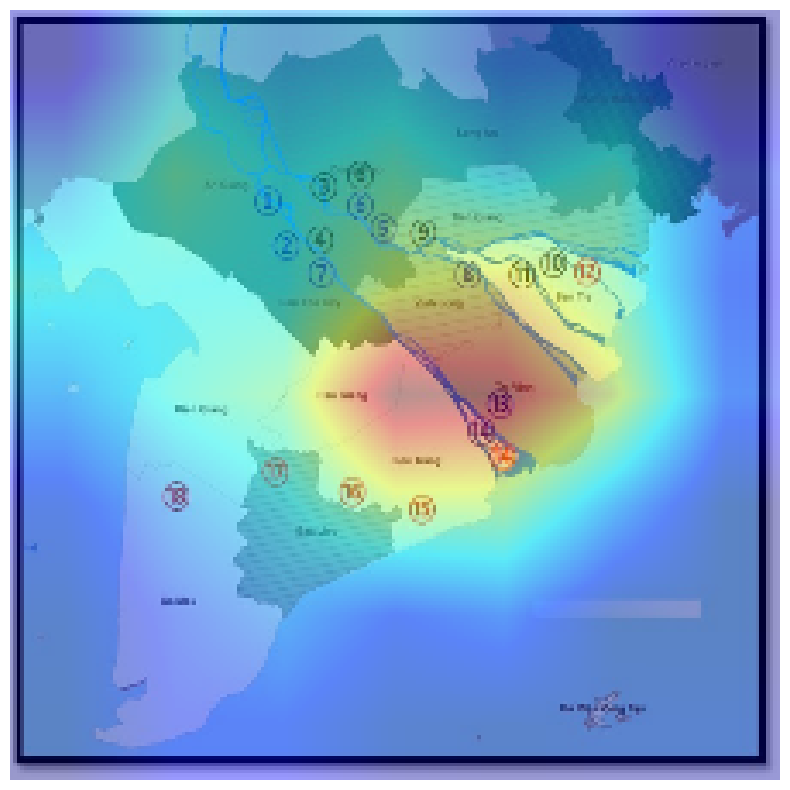

In [1]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import timm
from load_model import *
# --- Load ảnh và tiền xử lý ---
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # hoặc kích thước bạn dùng khi huấn luyện
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0)  # (1, 3, H, W)

# --- Grad-CAM cho ConvNeXt ---
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model.eval()
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Hook để lưu lại gradient và feature map
        self.forward_hook = self.target_layer.register_forward_hook(self._forward_hook)
        self.backward_hook = self.target_layer.register_backward_hook(self._backward_hook)

    def _forward_hook(self, module, input, output):
        self.activations = output.detach()

    def _backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def generate(self, input_tensor, class_idx=None):
        output = self.model(input_tensor)  # forward
        if class_idx is None:
            class_idx = output.argmax(dim=1).item()

        self.model.zero_grad()
        class_score = output[0, class_idx]
        class_score.backward()

        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])  # (C,)
        weighted_activations = self.activations[0] * pooled_gradients[:, None, None]
        cam = weighted_activations.sum(dim=0).cpu().numpy()

        # Normalize CAM
        cam = np.maximum(cam, 0)
        cam = cam / cam.max()
        cam = cv2.resize(cam, (224, 224))

        return cam

def show_gradcam_on_image(img_path, cam):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    
    # Chuyển cam về [0, 255] và uint8
    cam_uint8 = np.uint8(255 * cam)

    # Tạo heatmap
    heatmap = cv2.applyColorMap(cam_uint8, cv2.COLORMAP_JET)

    # Overlay: giữ heatmap dạng uint8, clip kết quả sau khi cộng
    superimposed_img = cv2.addWeighted(heatmap, 0.4, img, 0.6, 0)


    plt.figure(figsize=(8, 8))
    # plt.title("Grad-CAM")
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.tight_layout()
    plt.show()


# --- Load model và gọi Grad-CAM ---
def gradcam_convnextv2(image_path, model_path):
    # Load ConvNeXt V2 Tiny đã fine-tune
    model = load_convnextv2_model(model_path, num_classes=11, model_type="convnext_v2_raw")


        # Lấy lớp cuối cùng của backbone
    target_layer = model.stages[-1].blocks[-1]

    grad_cam = GradCAM(model, target_layer)
    input_tensor = preprocess_image(image_path)
    cam = grad_cam.generate(input_tensor)

    show_gradcam_on_image(image_path, cam)

# --- Chạy ---
if __name__ == "__main__":
    NUM_CLASSES = 11  # số lớp của bạn
    img_path = r"E:\LuanVan\data\raw\Maps\04-BE-VO NAM SON(24-38)004_page_26_img_1.png"
    model_path = r"E:\NghienCuuKhoaHoc\MODEL\convnext_v2\convnext_v2_best_params.pth"  # model đã train
    gradcam_convnextv2(img_path, model_path)


Incepv4

e:\NghienCuuKhoaHoc\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
e:\NghienCuuKhoaHoc\venv\Lib\site-packages\torch\nn\modules\module.py:1842: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


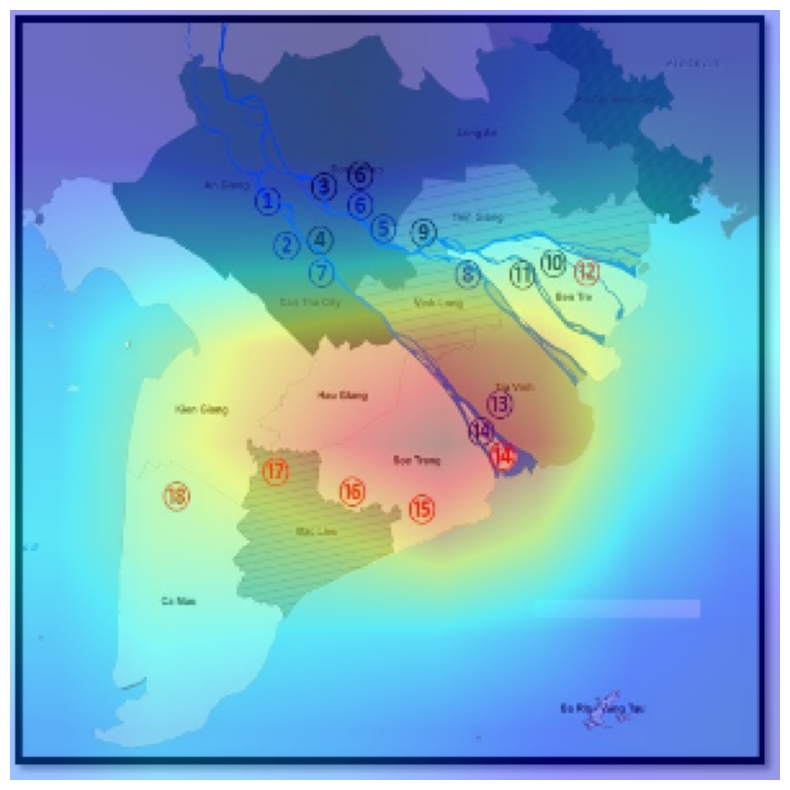

In [1]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import timm
from load_model import *

# --- Load ảnh và tiền xử lý ---
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((299, 299)),  # InceptionV4 dùng 299x299
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0)  # (1, 3, H, W)

# --- Grad-CAM ---
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model.eval()
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        self.forward_hook = self.target_layer.register_forward_hook(self._forward_hook)
        self.backward_hook = self.target_layer.register_backward_hook(self._backward_hook)

    def _forward_hook(self, module, input, output):
        self.activations = output.detach()

    def _backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def generate(self, input_tensor, class_idx=None):
        output = self.model(input_tensor)
        if isinstance(output, tuple):  # một số inception trả tuple
            output = output[0]

        if class_idx is None:
            class_idx = output.argmax(dim=1).item()

        self.model.zero_grad()
        class_score = output[0, class_idx]
        class_score.backward()

        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        weighted_activations = self.activations[0] * pooled_gradients[:, None, None]
        cam = weighted_activations.sum(dim=0).cpu().numpy()

        cam = np.maximum(cam, 0)
        cam = cam / (cam.max() + 1e-8)
        cam = cv2.resize(cam, (299, 299))
        return cam

# --- Hiển thị Grad-CAM ---
def show_gradcam_on_image(img_path, cam):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (299, 299))
    cam_uint8 = np.uint8(255 * cam)
    heatmap = cv2.applyColorMap(cam_uint8, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(heatmap, 0.4, img, 0.6, 0)

    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# --- Grad-CAM main function ---
def gradcam_inceptionv4(image_path, model_path):
    # model = load_inceptionv4_model(model_path)
    model = load_inceptionv4_raw_model(model_path)

    # Với InceptionV4 của timm, thường dùng layer cuối cùng của features
    # Có thể cần inspect: print(model)
    target_layer = model.features[-1]  # hoặc thử model.features[-2]

    grad_cam = GradCAM(model, target_layer)
    input_tensor = preprocess_image(image_path)
    cam = grad_cam.generate(input_tensor)

    show_gradcam_on_image(image_path, cam)
   
# --- Chạy ---
if __name__ == "__main__":
    img_path = r"E:\LuanVan\data\raw\Maps\04-BE-VO NAM SON(24-38)004_page_26_img_1.png"
    model_path = r"E:\NghienCuuKhoaHoc\MODEL\inception_v4\incepV4.pth"
    gradcam_inceptionv4(img_path, model_path)
